# Problem Definition and EDA

Computer vision, object detection and classification are some of the most popular and interesting problems in Machine Learning. The good thing is that they are easily applicable to real life problems. In this research we'll try to build the best possible classifier that will tell us what type of breed is in the picture. 

It feels like everyone is having a dog nowadays and I've always wondered about specific breed that I met while walking down the street or the park.

This project follow the full cycle of DL work with diagnosing the problem and the dataset, looking for best hyperparameters with exhausting Grid Search, training the best model and finally debugging and testing. Due to the character of the dataset and the generalizing powers I decided that creating a small Web Application to test it beyond the usual ways will be helpful. Also to gather more links for future training. Go to this [adress](http://dogsbreed.ml/) if curious about how the model does in production environment.

## Dataset

People have been "mixing" dogs breed for centuries. The exact number known to us varies from source to source. Different google searches displayed different results. But the number is more than 400 and less than 2000, at least when I last searched. Most of them were between 400 and 500 so we'll accept this for the moment.

Trying to find the appropriate data wasn't easy. Thankfully Tensorflow Datasets Api came along so this process is rather easy. Let's actually see what we have to deal with it. This dataset consists of 'only' 120 so keep that in mind when testing it with pictures.

In [17]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [18]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True, shuffle_files=True)

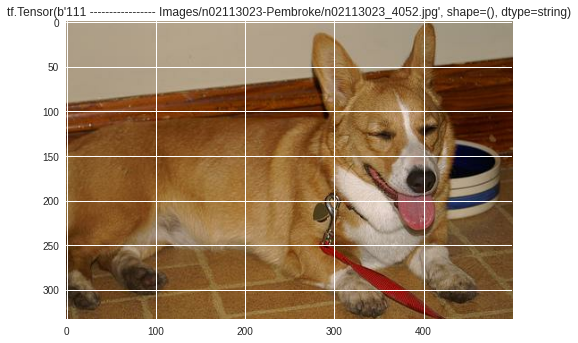

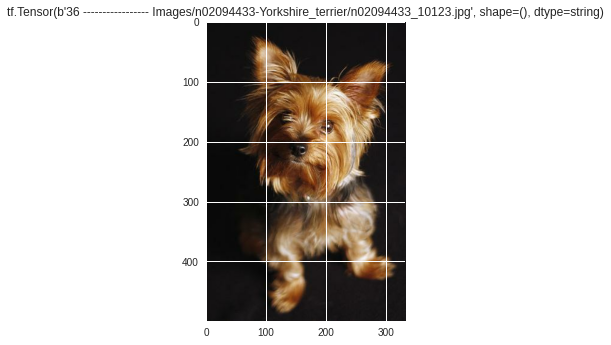

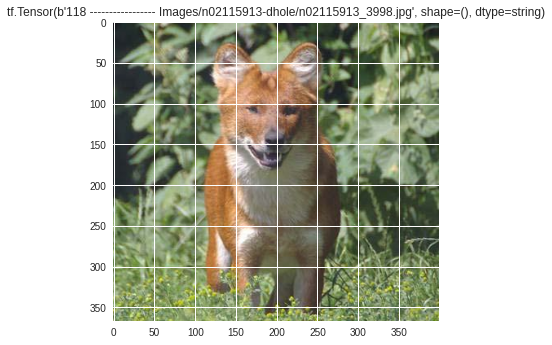

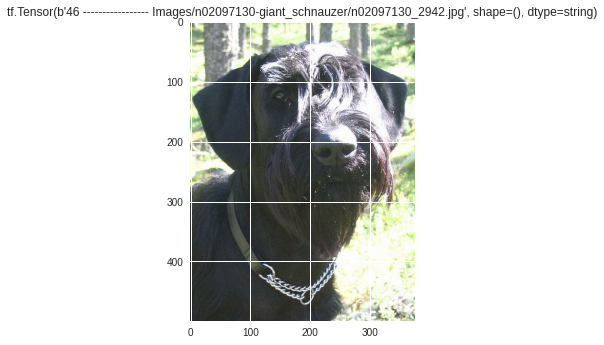

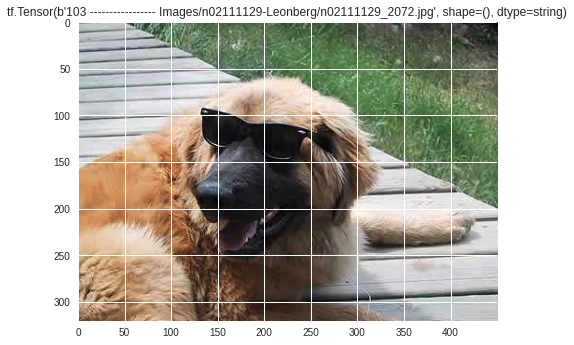

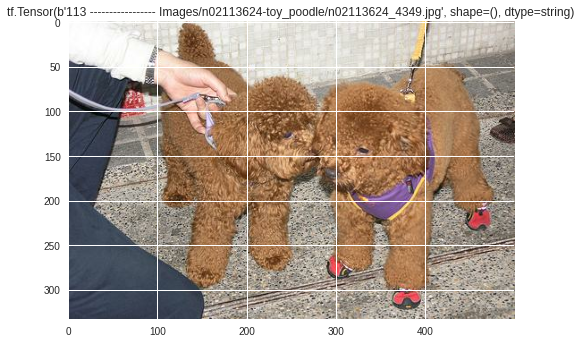

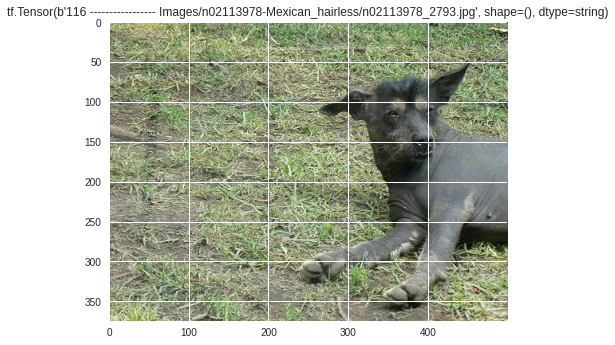

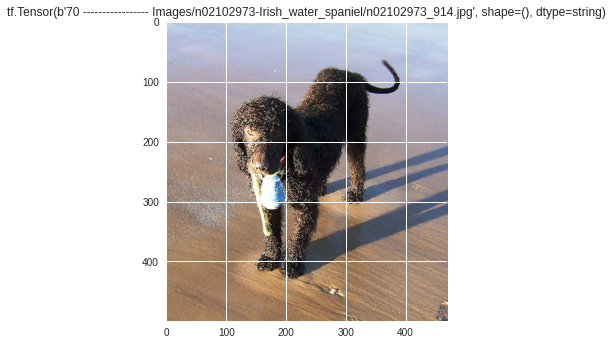

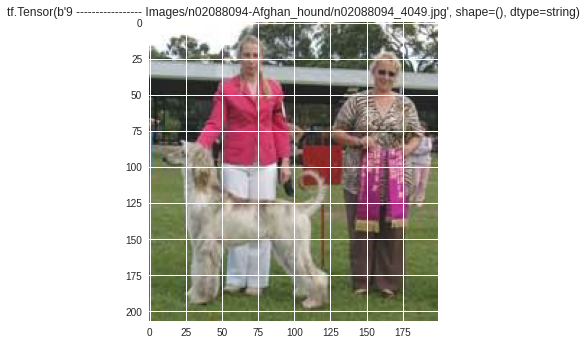

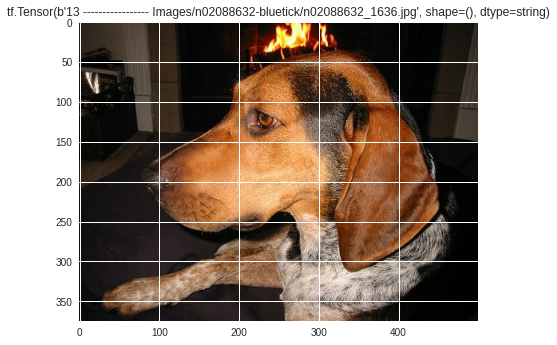

In [19]:
sample_of_10 = []
for x in dataset['train'].take(10):
  plt.imshow(x['image'])
  sample_of_10.append(x['image'])
  plt.title(str(x['label'].numpy()) + " ----------------- "+  x['image/filename'])
  plt.show()


---
Don't worry about the Grid, this is because of the Plt style that I applied(can't stand the default). I only show 10 random pictures here but I examined much more than that while trying to get the names of labels(surprisingly there were nowhere to be found in Internet).

## EDA

Let's make an EDA of the Data with a bit bigger sample. 100 should be enough. It's image dataset so the dimensions are crucial and most problematic so let's start with it.

In [20]:
sample_of_100 = [x['image'] for x in dataset['train'].take(100)]

In [21]:
arr_of_heights = [x.shape[0] for x in sample_of_100]
arr_of_widths = [x.shape[1] for x in sample_of_100]


In [22]:
def get_dimensions(arr_of_heights, arr_of_widths, title1, title2):
  plt.hist(arr_of_heights)
  plt.xlabel('Height')
  plt.ylabel('Count')
  plt.title(title1)
  plt.show()

  plt.hist(arr_of_widths)
  plt.xlabel('Width')
  plt.ylabel('Count')
  plt.title(title2)
  plt.show()

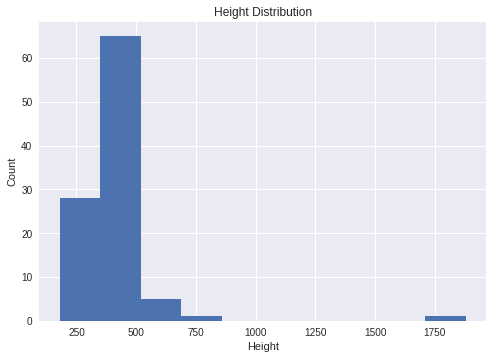

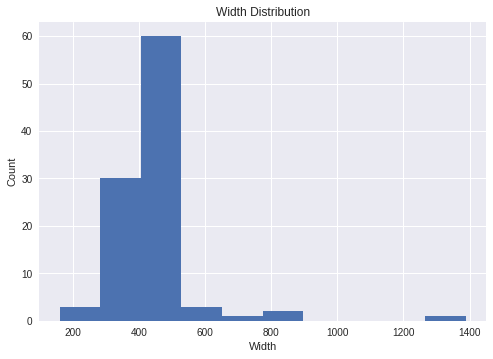

In [23]:
get_dimensions(arr_of_heights, arr_of_widths, 'Height Distribution', 'Width Distribution')


---
Well most of the datasets in TensorFlow and Keras API are prepared but not this one. Aparently we'll have to resize the data since it varies a lot. Even in this relatively small sample of 100 we found a very distant outlier 3 times bigger than the average. 

Another problem is dealing with the colors. You'll often see in such type of tasks researchers to get rid of some of the dimensions by turning the images intro gray ones. This, I'm afraid, is not an option here. The colors should be of extreme importance for the model. Some of the breeds are very hard to distinguish from one another. So we'll need and use this information to its fullest extent. 

Now let's check the raw numbers.


In [24]:
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

So we have about 12000 for training and 8580 for test. Not much for 120 labels.. Turning this into a dataframe or numpy is very ram consuming so we can't display easily graphically the number of observations for each label but you can find them here on the left:

http://vision.stanford.edu/aditya86/ImageNetDogs/

Every single breed is presented by at least 150 images so at least that's good. We are not going to take any actions in that direction for now. 

So finally - we'll make a data augmentation for sure, we'll use the provided 'test' split for validation in place and the real test we'll be performed in a very client-friendly way by putting pictures from urls directly from internet. At the end we can even use the web application to test it us much as we want easily.



## Strategy to solve the problem


### Previous Work

This dataset is among the difficult ones for classification. It has relatively small amount of observations per label, some of them are too big and this will affect when resizing, there are people in it, even different breeds on the same picture. 

Some of the most popular places to get a good idea of what's been achieved so far:

https://paperswithcode.com/sota/fine-grained-image-classification-on-stanford-1

http://vision.stanford.edu/aditya86/ImageNetDogs/

https://www.kaggle.com/c/dog-breed-identification/notebooks


## Transfer Learning Choice

You can observe in Kaggle notebook some interesting attempts to build a model from scratch. But the best performances are by already established models. This is what we are going to do here as well. 

As strange as it is I couldn't find any attempts to 'solve' the dataset with some of the most famous and and State of the Art powerful models at time. There are reported attempts with API-net(90% accuracy, currently highest), SEF(88.8), DenseNet(83.75) and EfficientNet, this article here https://www.angioi.com/dog-breed-classification/ uses the popular MobileNetV2 and records 71% accuracy on validation data. We'll focus on VGG, Resnet and Inception-Resnet as 3 powerful and famous models that use very different architectures and are expected to give us different results. 

Now we head to tuning part. We'll use these models as base, we'll freeze everything up to GlobalAveragePooling/Flatten layers and we will rewrite the FNN layers in order to work for our case. Since they are veeery big models(Inception-Resnet is almost 800 layers) we are not going to add a lot of dense layers to the convolutional architecture. We'll try with only one softmax layer, 2 Dense Layers and 3 Dense layers with the respective regularization techniques of course.


## Sources:

1) http://vision.stanford.edu/aditya86/ImageNetDogs/ - dataset

2) https://paperswithcode.com/sota/fine-grained-image-classification-on-stanford-1 - cited benchmark scores in the final section

3) https://www.kaggle.com/c/dog-breed-identification/notebooks - cited notebooks scores in the final section